<a href="https://colab.research.google.com/github/larissavaladao/time_series_curuai/blob/main/5.%20parameters_by_period/7.land_cover_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar pacotes

In [1]:
import geopandas as gpd
import pandas as pd
import math
import ee
import geemap
import json

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-curuai2')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import image collections

Landsat 7 - PY6S

In [4]:
landsat7 = ee.ImageCollection("projects/ee-curuai/assets/Py6S/LD7/Landsat7")\
            .select([ 'B1', 'B2', 'B3', 'B4', 'B5', 'B7'])
print(ee.Date(landsat7.sort('system:time_start',True).first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat7.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

2000-01-24T13:46:48
2024-01-16T11:16:49


Landsat 8 PY6S

In [5]:
landsat8 = (ee.ImageCollection("projects/ee-curuai/assets/Py6S/LD8/Landsat8")
            .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7']))
print(ee.Date(landsat8.sort('system:time_start',True).first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat8.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

2013-05-11T13:55:54
2024-12-12T13:47:48


Landsat 9 PY6S

In [6]:
landsat9 = (ee.ImageCollection("projects/ee-curuai2/assets/Py6S/LD9/Landsat9")
            .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7']))
print(ee.Date(landsat9.sort('system:time_start',True).first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat9.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

2021-11-06T13:49:55
2024-12-27T13:54:34


# Transform into remote sensing reflectance

In [7]:
def rs_reflectance (img):
  '''#dividir imagem corrigida por pi
  Rrs_sat_ac = Rsat_ac / pi
  '''
  Rrs = img.divide(math.pi).select(['blue_mean','green_mean','red_mean','nir_mean','swir1','swir2'])


  return (Rrs
          .copyProperties(img,['system:time_start','CLOUD_COVER',"system:index"]))

# Padronize band names

In [8]:
name_bands = ['blue_mean','green_mean','red_mean','nir_mean','swir1','swir2']

Landsat 7

In [9]:
#renomear bandas
ld7 = landsat7.map(lambda img: img.rename(name_bands)).map(rs_reflectance)
display(ld7.size().getInfo())

1366

Landsat 8

In [10]:
ld8 = landsat8.map(lambda img: img.rename(name_bands)).map(rs_reflectance)
display(ld8.size().getInfo())

743

landsat 9

In [11]:
ld9 = landsat9.map(lambda img: img.rename(name_bands)).map(rs_reflectance)
display(ld9.size().getInfo())

208

# Juntar coleções landsat

In [12]:
merge_col = ld8.merge(ld7).merge(ld9).sort('system:time_start')
merge_col.limit(5)

In [13]:
merge_col.size()

# Importar dados de periodo baseado na vazao de obidos

In [14]:
#import period dates
df_period_limits = pd.read_csv('/content/drive/MyDrive/CURUAI_PROCESS/water_period_limits.csv').drop(columns=['Unnamed: 0'])
# df_period_limits['Data'] = pd.to_datetime(df_period_limits['Data'])
df_period_limits

,Data,type,day,month,year,longitude,latitude
0,2000-01-13 10:43:38.181818240,LW_to_R,13,1,2000,-55.5131,-1.9192
1,2000-02-29 18:17:42.295081984,R_to_HW,29,2,2000,-55.5131,-1.9192
2,2000-08-24 20:45:42.857142784,HW_to_F,24,8,2000,-55.5131,-1.9192
3,2000-09-28 10:23:44.598930432,F_to_LW,28,9,2000,-55.5131,-1.9192
4,2001-01-05 16:27:54.418604672,LW_to_R,5,1,2001,-55.5131,-1.9192
...,...,...,...,...,...,...,...
95,2023-08-25 18:37:31.737451520,F_to_LW,25,8,2023,-55.5131,-1.9192
96,2024-01-26 18:57:28.739495680,LW_to_R,26,1,2024,-55.5131,-1.9192
97,2024-03-25 23:32:02.330097152,R_to_HW,25,3,2024,-55.5131,-1.9192
98,2024-04-06 10:42:51.428571648,HW_to_F,6,4,2024,-55.5131,-1.9192


# Fazer mosaico definido por cota

In [15]:
list_images = []
for i in range(0,len(df_period_limits)-1):
  # print(df_period_limits['Data'][i][0:10])
  # print(df_period_limits['Data'][i+1][0:10])

  image = (merge_col.filter(ee.Filter.date(df_period_limits['Data'][i][0:10],df_period_limits['Data'][i+1][0:10]))
              .median())
  if int(image.bandNames().length().getInfo()) > 0:
    list_images.append(image
              .set('year', str(df_period_limits['year'][i]))
              .set('month_init', str(df_period_limits['month'][i]))
              .set('month_end', str(df_period_limits['month'][i+1]))
              .set('system:time_start', ee.Date.parse('yyyy-MM-dd',str(df_period_limits['Data'][i][0:10])))
              .set('time_start', str(df_period_limits['Data'][i][0:10]))
              .set('time_finish', str(df_period_limits['Data'][i+1][0:10]))
              .set('band_count',image.bandNames().length()))



len(list_images)

98

In [16]:
list_images.append(merge_col.filterDate('2024-05-30','2025-01-01').median()
              .set('year', str(2024))
              .set('month_init', str('05'))
              .set('month_end', str(12))
              .set('system:time_start', ee.Date.parse('yyyy-MM-dd',str('2024-05-30')))
              .set('time_start', str('2024-05-30'))
              .set('time_finish', str('2025-01-01'))
              .set('band_count',image.bandNames().length()))

In [25]:
filtro = ee.ImageCollection('projects/ee-curuai2/assets/landsat_water_period/water_period_discharge').aggregate_array('time_start')
period_mosaics =  ee.ImageCollection.fromImages(ee.List(list_images)).filter(ee.Filter.inList('time_start', filtro))
period_mosaics.size()

In [ ]:
Map = geemap.Map(basemap='HYBRID')

Map.addLayer(period_mosaics.first(),{},'teste')
Map


# Classificar Imagens

In [ ]:
# classe

Desmistura espectral? k means? random forest? indice espectral?

dados mapbiomas? PRODES? DETER? MAPBIOMAS ALERTA?

# mapbiomas curuai

In [75]:
import pandas as pd
df_classes_area = pd.read_csv('/content/drive/MyDrive/MAPBIOMAS-EXPORT-curuai/mapbiomas-brazil-collection-90-area.csv').drop(columns =['.geo','system:index'])

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MAPBIOMAS-EXPORT-curuai/mapbiomas-brazil-collection-90-arean2.csv'

In [41]:
df_classes_area['year'] = df_classes_area['band'].apply(lambda name: int(name[-4:]))
df_classes_area

,area_km2,band,class,class_name,year
0,1069.685224,classification_2000,3,Forest Formation,2000
1,0.413587,classification_2000,4,Savanna Formation,2000
2,451.091861,classification_2000,6,Áreas Naturales Inundables - Leñosas (Bosque I...,2000
3,626.141351,classification_2000,11,Wetland,2000
4,11.472356,classification_2000,12,"Grassland (Pastizal, Formación Herbácea)",2000
...,...,...,...,...,...
232,254.774877,classification_2023,15,Pasture,2023
233,10.282167,classification_2023,24,Urban Infrastructure,2023
234,9.586696,classification_2023,25,Other Non Vegetated Area,2023
235,1407.783843,classification_2023,33,"River, Lake and Ocean",2023


In [59]:
df_classes_area['class_name'].unique()

array(['Forest Formation', 'Savanna Formation',
       'Áreas Naturales Inundables - Leñosas (Bosque Inundable)',
       'Wetland', 'Grassland (Pastizal, Formación Herbácea)', 'Pasture',
       'Urban Infrastructure', 'Other Non Vegetated Area',
       'River, Lake and Ocean', 'Mosaic of Crops'], dtype=object)

In [82]:
dados_non_nat = df_classes_area.loc[df_classes_area['class_name'].isin(['Pasture',
       'Urban Infrastructure', 'Other Non Vegetated Area','Mosaic of Crops','River, Lake and Ocean'])].copy()
dados_non_nat = dados_non_nat.groupby(by=['year']).sum()
dados_non_nat['class_name'] = 'Non-natural'
dados_non_nat

,area_km2,band,class,class_name
year,,,,
2000,1643.774069,classification_2000classification_2000classifi...,97,Non-natural
2001,1618.818333,classification_2001classification_2001classifi...,97,Non-natural
2002,1660.812290,classification_2002classification_2002classifi...,97,Non-natural
2003,1617.557840,classification_2003classification_2003classifi...,138,Non-natural
2004,1604.544608,classification_2004classification_2004classifi...,138,Non-natural
2005,1696.531117,classification_2005classification_2005classifi...,138,Non-natural
2006,1736.366400,classification_2006classification_2006classifi...,138,Non-natural
2007,1763.504874,classification_2007classification_2007classifi...,138,Non-natural
2008,1786.568230,classification_2008classification_2008classifi...,138,Non-natural


In [83]:
dados_nat = df_classes_area.loc[~df_classes_area['class_name'].isin(['Pasture',
       'Urban Infrastructure', 'Other Non Vegetated Area','Mosaic of Crops','River, Lake and Ocean'])].copy()
dados_nat = dados_nat.groupby(by=['year']).sum()
dados_nat['class_name'] = 'Natural'
dados_nat

,area_km2,band,class,class_name
year,,,,
2000,2158.804379,classification_2000classification_2000classifi...,36,Natural
2001,2183.760115,classification_2001classification_2001classifi...,36,Natural
2002,2141.766158,classification_2002classification_2002classifi...,36,Natural
2003,2185.020608,classification_2003classification_2003classifi...,36,Natural
2004,2198.033840,classification_2004classification_2004classifi...,36,Natural
2005,2106.047331,classification_2005classification_2005classifi...,36,Natural
2006,2066.212048,classification_2006classification_2006classifi...,36,Natural
2007,2039.073574,classification_2007classification_2007classifi...,36,Natural
2008,2016.010218,classification_2008classification_2008classifi...,36,Natural


In [84]:
dados = pd.concat([dados_nat,dados_non_nat])
dados

,area_km2,band,class,class_name
year,,,,
2000,2158.804379,classification_2000classification_2000classifi...,36,Natural
2001,2183.760115,classification_2001classification_2001classifi...,36,Natural
2002,2141.766158,classification_2002classification_2002classifi...,36,Natural
2003,2185.020608,classification_2003classification_2003classifi...,36,Natural
2004,2198.033840,classification_2004classification_2004classifi...,36,Natural
2005,2106.047331,classification_2005classification_2005classifi...,36,Natural
2006,2066.212048,classification_2006classification_2006classifi...,36,Natural
2007,2039.073574,classification_2007classification_2007classifi...,36,Natural
2008,2016.010218,classification_2008classification_2008classifi...,36,Natural


<Axes: xlabel='year', ylabel='area_km2'>

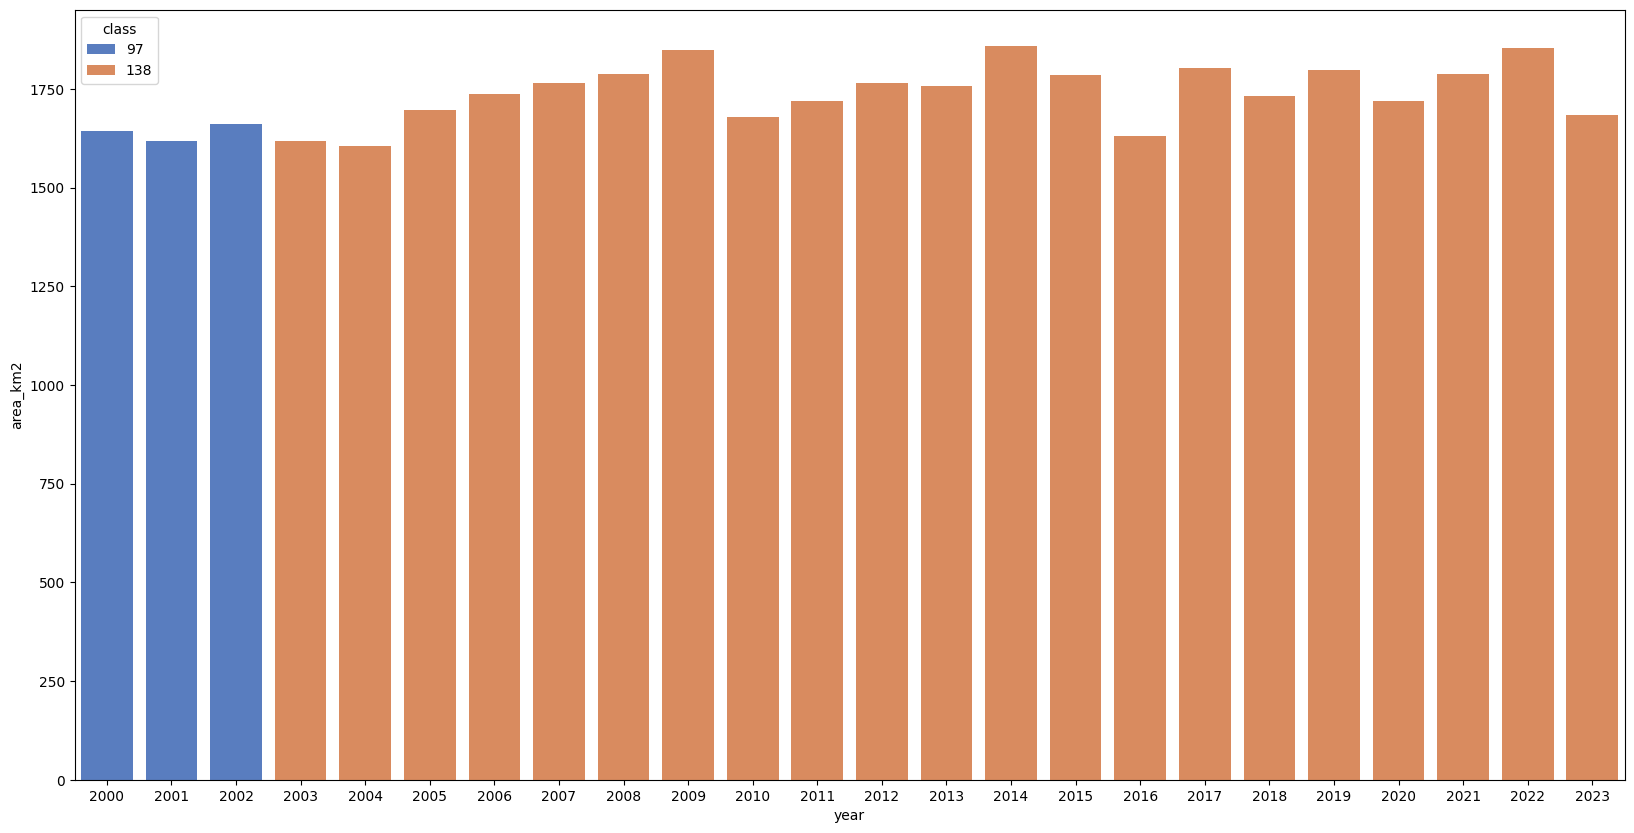

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt



# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

sns.barplot(data=dados_non_nat,x='year',y='area_km2',hue='class',palette="muted")

# mapbiomas bacia nivel 2

In [86]:
import pandas as pd
df_classes_area = pd.read_csv('/content/drive/MyDrive/MAPBIOMAS-EXPORT-curuai/mapbiomas-brazil-collection-90-area-n2.csv').drop(columns =['.geo','system:index'])

In [87]:
df_classes_area['year'] = df_classes_area['band'].apply(lambda name: int(name[-4:]))
df_classes_area

,area_km2,band,class,class_name,year
0,0.036607,classification_2000,0,Non Observed,2000
1,311400.168695,classification_2000,3,Forest Formation,2000
2,540.686122,classification_2000,4,Savanna Formation,2000
3,18742.935339,classification_2000,6,Áreas Naturales Inundables - Leñosas (Bosque I...,2000
4,0.007147,classification_2000,9,Forest Plantation,2000
...,...,...,...,...,...
360,269.130859,classification_2023,29,Rocky outcrop,2023
361,283.118351,classification_2023,30,Mining,2023
362,19494.180916,classification_2023,33,"River, Lake and Ocean",2023
363,3.449346,classification_2023,39,Soy Beans,2023


In [88]:
df_classes_area['class_name'].unique()

array(['Non Observed', 'Forest Formation', 'Savanna Formation',
       'Áreas Naturales Inundables - Leñosas (Bosque Inundable)',
       'Forest Plantation', 'Wetland',
       'Grassland (Pastizal, Formación Herbácea)', 'Pasture',
       'Urban Infrastructure', 'Other Non Vegetated Area',
       'Rocky outcrop', 'Mining', 'River, Lake and Ocean',
       'Mosaic of Crops', 'Sugar Cane', 'Soy Beans'], dtype=object)

In [90]:
classes = ['Pasture',
       'Urban Infrastructure', 'Other Non Vegetated Area',
       'Rocky outcrop', 'Mining',
       'Mosaic of Crops', 'Sugar Cane', 'Soy Beans']
dados_non_nat = df_classes_area.loc[df_classes_area['class_name'].isin(classes)].copy()
dados_non_nat = dados_non_nat.groupby(by=['year']).sum()
dados_non_nat['class_name'] = 'Non-natural'
dados_non_nat

,area_km2,band,class,class_name
year,,,,
2000,5315.676245,classification_2000classification_2000classifi...,164,Non-natural
2001,5421.196847,classification_2001classification_2001classifi...,164,Non-natural
2002,5422.164862,classification_2002classification_2002classifi...,184,Non-natural
2003,5637.086217,classification_2003classification_2003classifi...,184,Non-natural
2004,5915.756384,classification_2004classification_2004classifi...,184,Non-natural
2005,6259.126038,classification_2005classification_2005classifi...,184,Non-natural
2006,6425.254308,classification_2006classification_2006classifi...,184,Non-natural
2007,6401.743741,classification_2007classification_2007classifi...,184,Non-natural
2008,6486.299043,classification_2008classification_2008classifi...,184,Non-natural


In [91]:
dados_nat = df_classes_area.loc[~df_classes_area['class_name'].isin(classes)].copy()
dados_nat = dados_nat.groupby(by=['year']).sum()
dados_nat['class_name'] = 'Natural'
dados_nat

,area_km2,band,class,class_name
year,,,,
2000,361249.224737,classification_2000classification_2000classifi...,78,Natural
2001,361143.704135,classification_2001classification_2001classifi...,78,Natural
2002,361142.736120,classification_2002classification_2002classifi...,78,Natural
2003,360927.814765,classification_2003classification_2003classifi...,78,Natural
2004,360649.144598,classification_2004classification_2004classifi...,78,Natural
2005,360305.774944,classification_2005classification_2005classifi...,78,Natural
2006,360139.646674,classification_2006classification_2006classifi...,78,Natural
2007,360163.157241,classification_2007classification_2007classifi...,78,Natural
2008,360078.601939,classification_2008classification_2008classifi...,78,Natural


In [92]:
dados = pd.concat([dados_nat,dados_non_nat])
dados

,area_km2,band,class,class_name
year,,,,
2000,361249.224737,classification_2000classification_2000classifi...,78,Natural
2001,361143.704135,classification_2001classification_2001classifi...,78,Natural
2002,361142.736120,classification_2002classification_2002classifi...,78,Natural
2003,360927.814765,classification_2003classification_2003classifi...,78,Natural
2004,360649.144598,classification_2004classification_2004classifi...,78,Natural
2005,360305.774944,classification_2005classification_2005classifi...,78,Natural
2006,360139.646674,classification_2006classification_2006classifi...,78,Natural
2007,360163.157241,classification_2007classification_2007classifi...,78,Natural
2008,360078.601939,classification_2008classification_2008classifi...,78,Natural


<Axes: xlabel='year', ylabel='area_km2'>

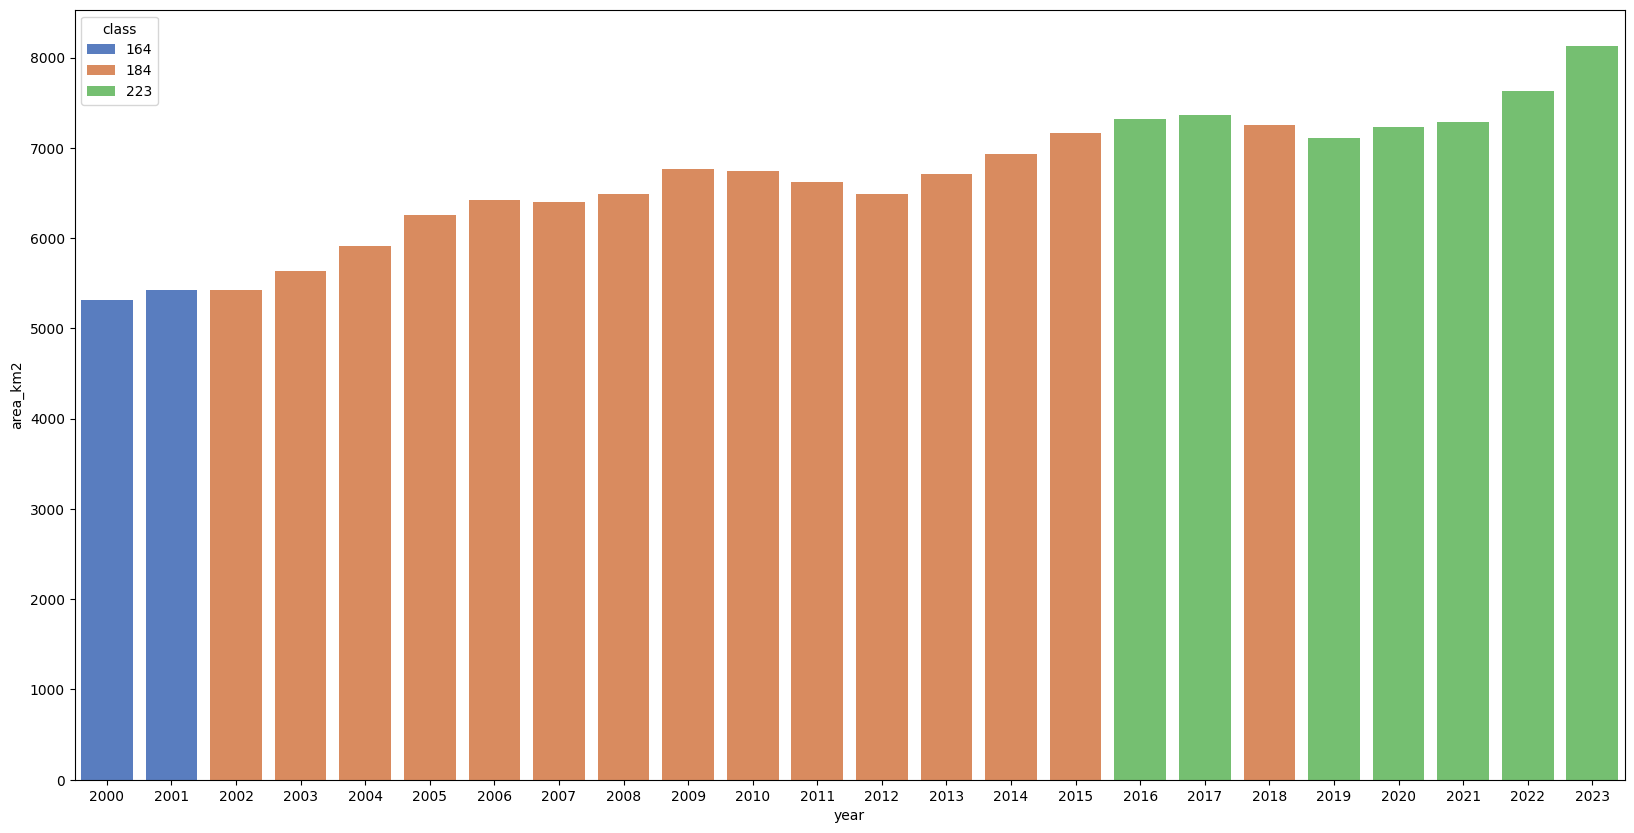

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt



# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

sns.barplot(data=dados_non_nat,x='year',y='area_km2',hue='class',palette="muted")